In [1]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (35,20)
import tqdm as tqdm

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
episodes = []
for i in range(5):
    episodes.append(pd.read_csv('data/SW/starwars_episode_{}_edges.csv'.format(i+1)))

In [3]:
all_episodes = pd.concat(episodes)

In [4]:
all_episodes.head()

,Source,Target,Type,weight,episode,Source_ID,value,Target_ID
0,2,1,undirected,1,1,QUI-GON,33,R2-D2
1,5,1,undirected,26,1,TC-14,5,R2-D2
2,9,1,undirected,1,1,TEY HOW,5,R2-D2
3,10,1,undirected,9,1,EMPEROR,14,R2-D2
4,12,1,undirected,22,1,SIO BIBBLE,8,R2-D2


In [5]:
edges = all_episodes.groupby(['Source_ID','Target_ID']).agg({'weight':'sum'}).reset_index()

In [6]:
edges.sort_values('weight',ascending=False).head()

,Source_ID,Target_ID,weight
163,LUKE,RIEEKAN,33
224,R2-D2,ANAKIN,30
153,LEIA,LUKE,27
284,TARKIN,C-3PO,26
300,TC-14,R2-D2,26


In [7]:
SW = nx.from_pandas_edgelist(edges, 
                            source='Source_ID',
                            target='Target_ID',
                            edge_attr='weight' )

In [8]:
print(nx.info(SW))


Name: 
Type: Graph
Number of nodes: 84
Number of edges: 342
Average degree:   8.1429


In [9]:
weighted_degrees = dict(nx.degree(SW,weight='weight'))
max_degree = max(weighted_degrees.values())

In [10]:
import seaborn as sns

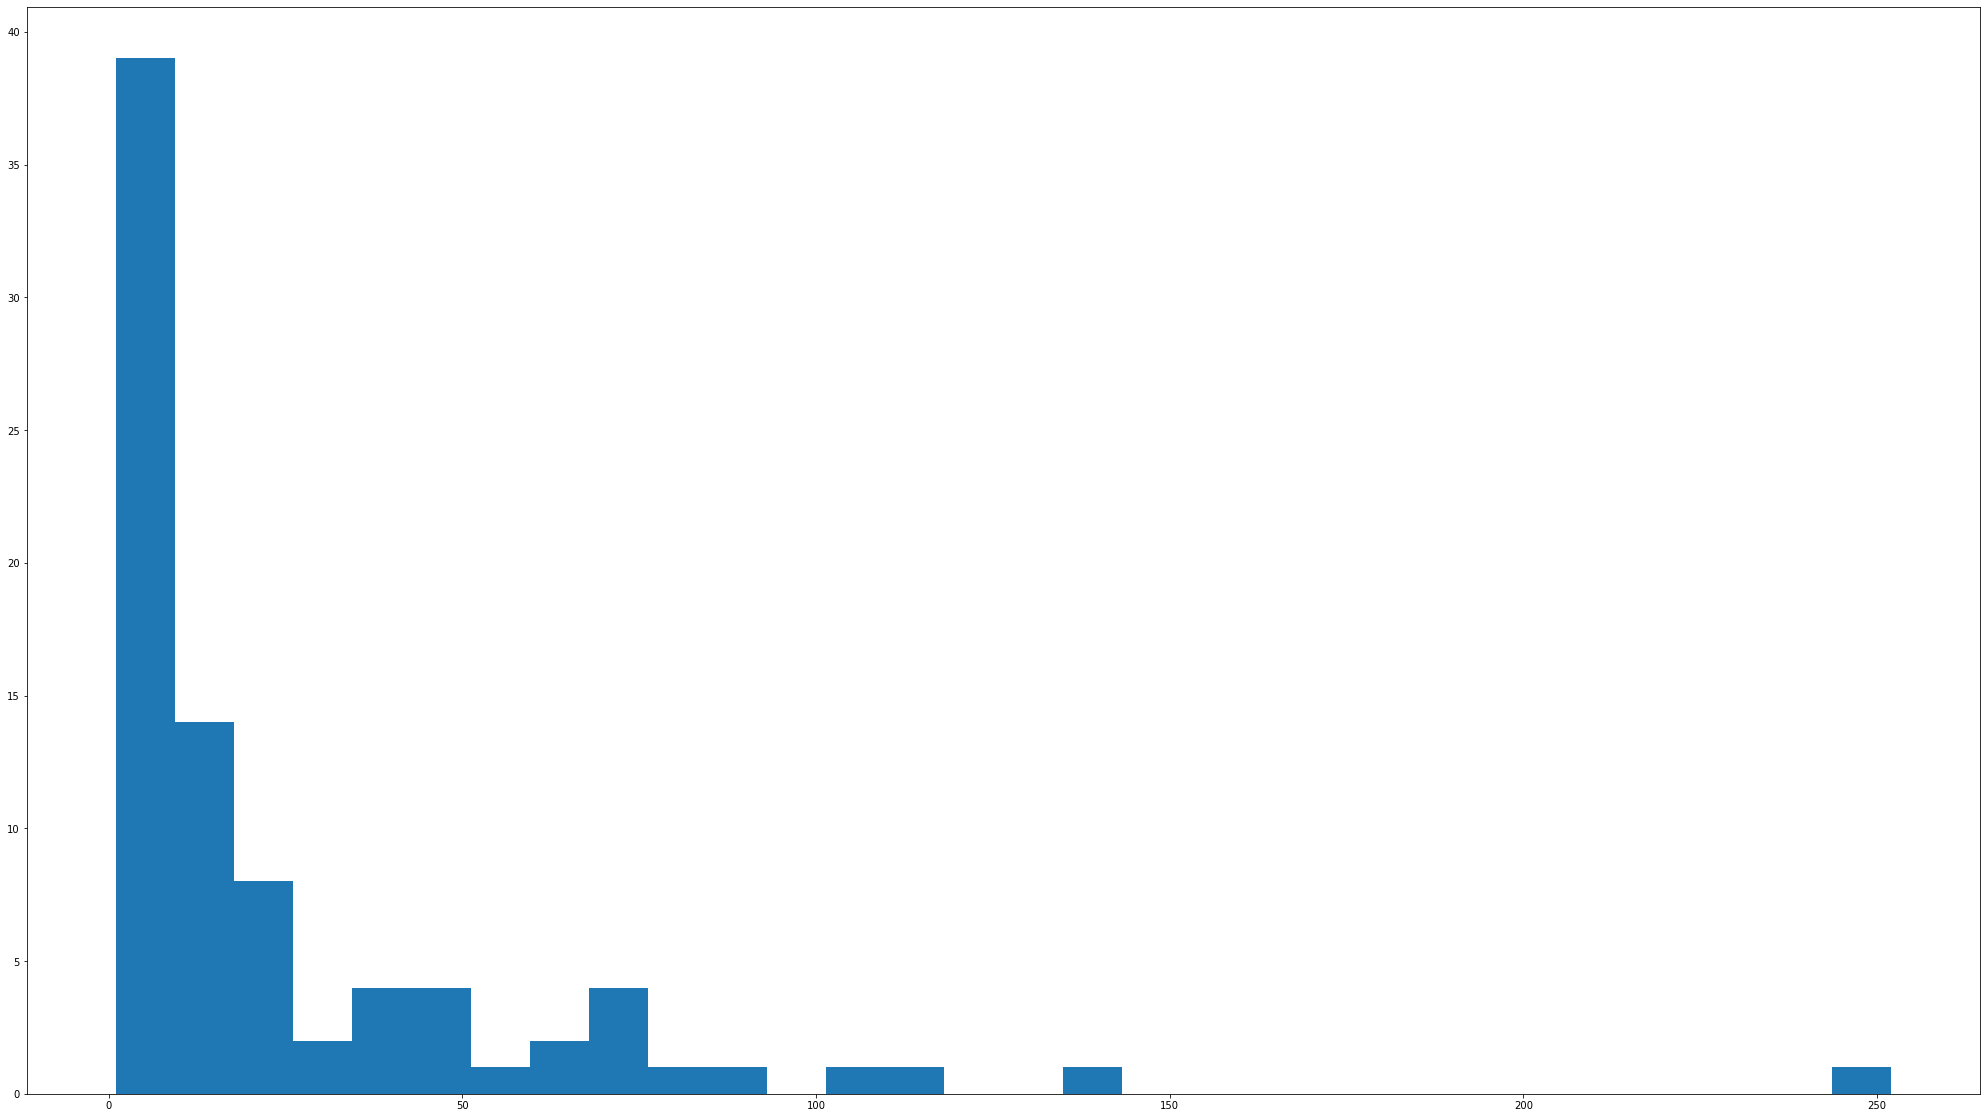

In [11]:
h = plt.hist(weighted_degrees.values(), bins = 30)


In [12]:
subG = SW.subgraph([n for n in weighted_degrees if weighted_degrees[n]>2])

In [13]:
print(nx.info(subG))

Name: 
Type: Graph
Number of nodes: 72
Number of edges: 323
Average degree:   8.9722


In [14]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

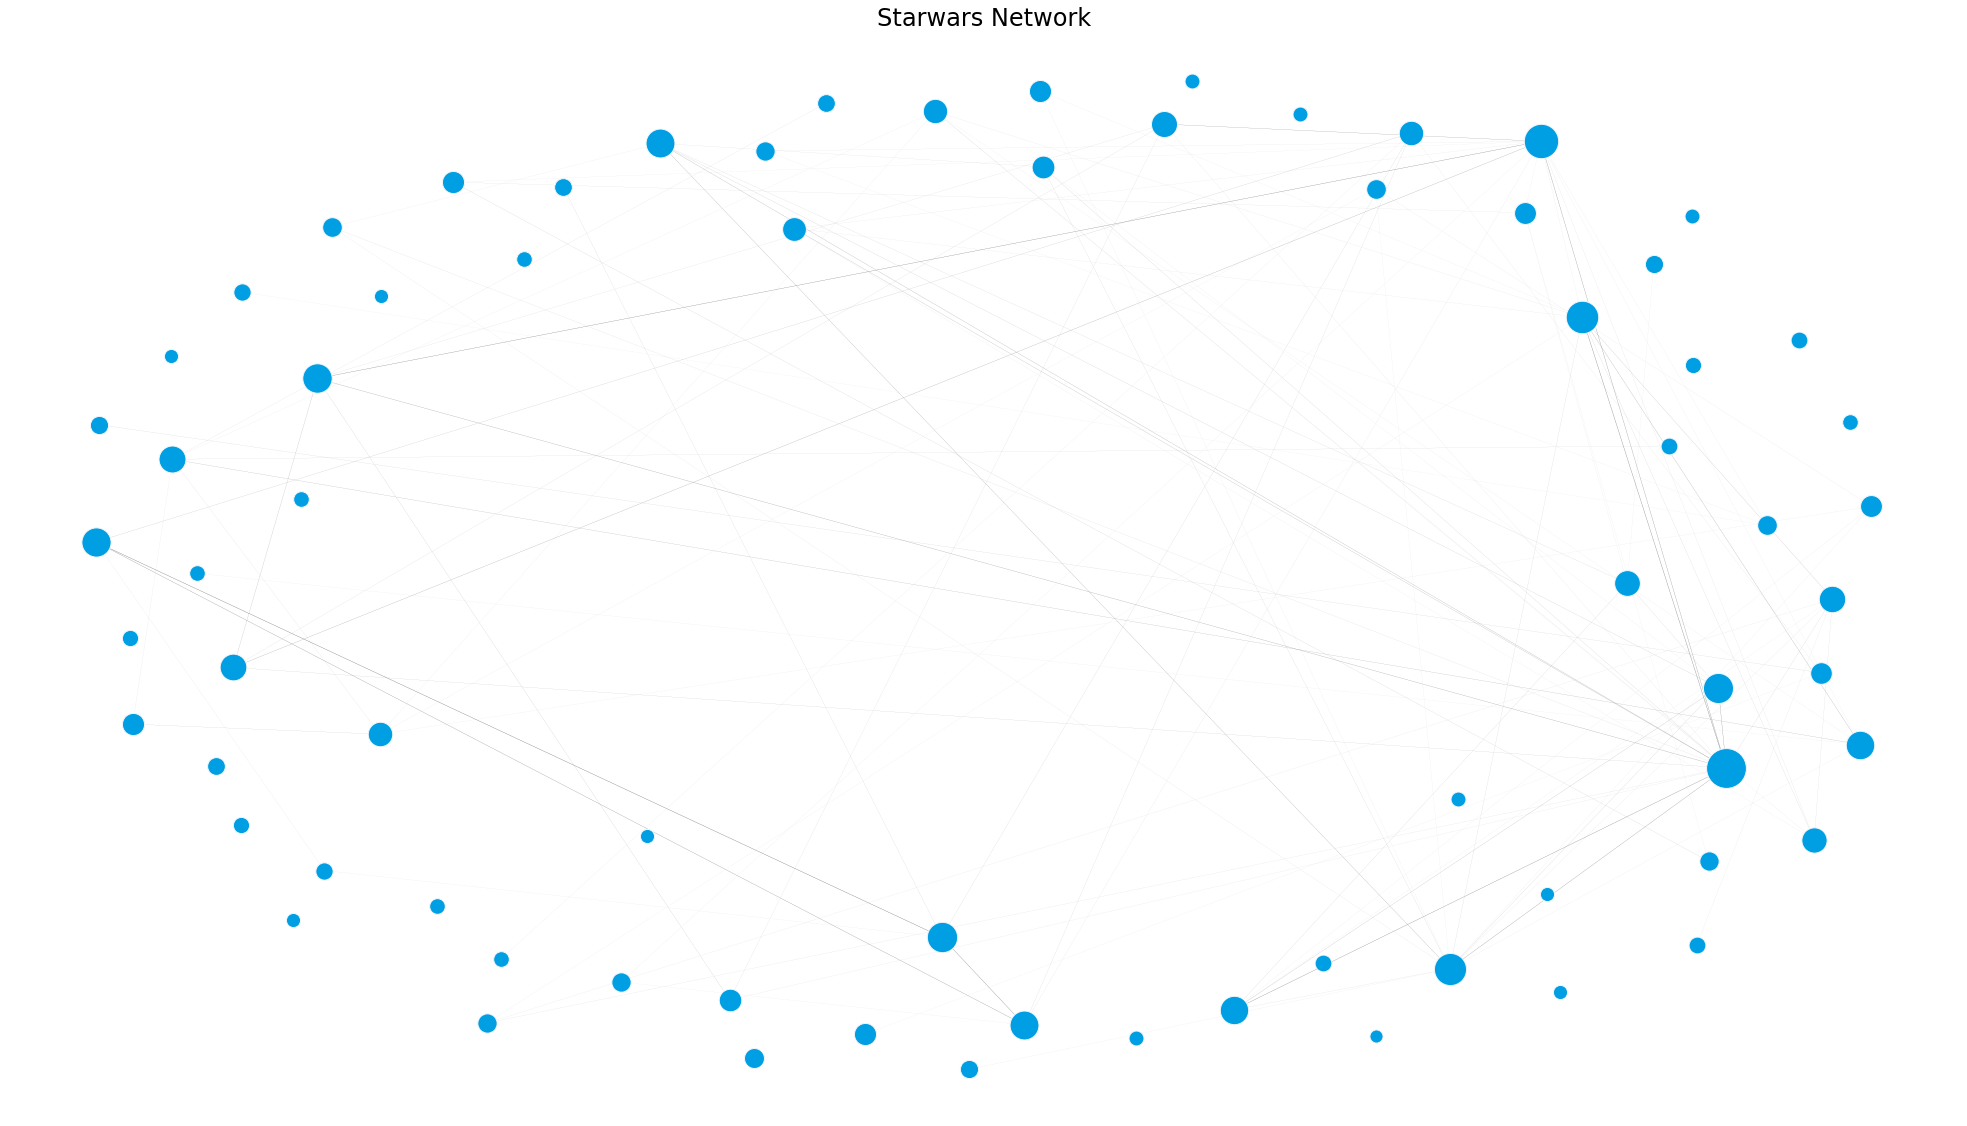

In [15]:
plt.axis('off')
plt.title('Starwars Network',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>1},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>2:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

In [16]:
infection_times = {}

In [17]:
def independent_cascade(G,t,infection_times):
    #doing a t->t+1 step of independent_cascade simulation
    #each infectious node infects neigbors with probabilty proportional to the weight
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    infection_times[v] = t+1
    return infection_times

In [21]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Star Wars Network, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#f2f6fa')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')


In [ ]:
#Beyond this I haven't adjusted

In [23]:
infection_times = {'LUKE':-1,'CHEWBACCA':-1,'R2-D2':0}

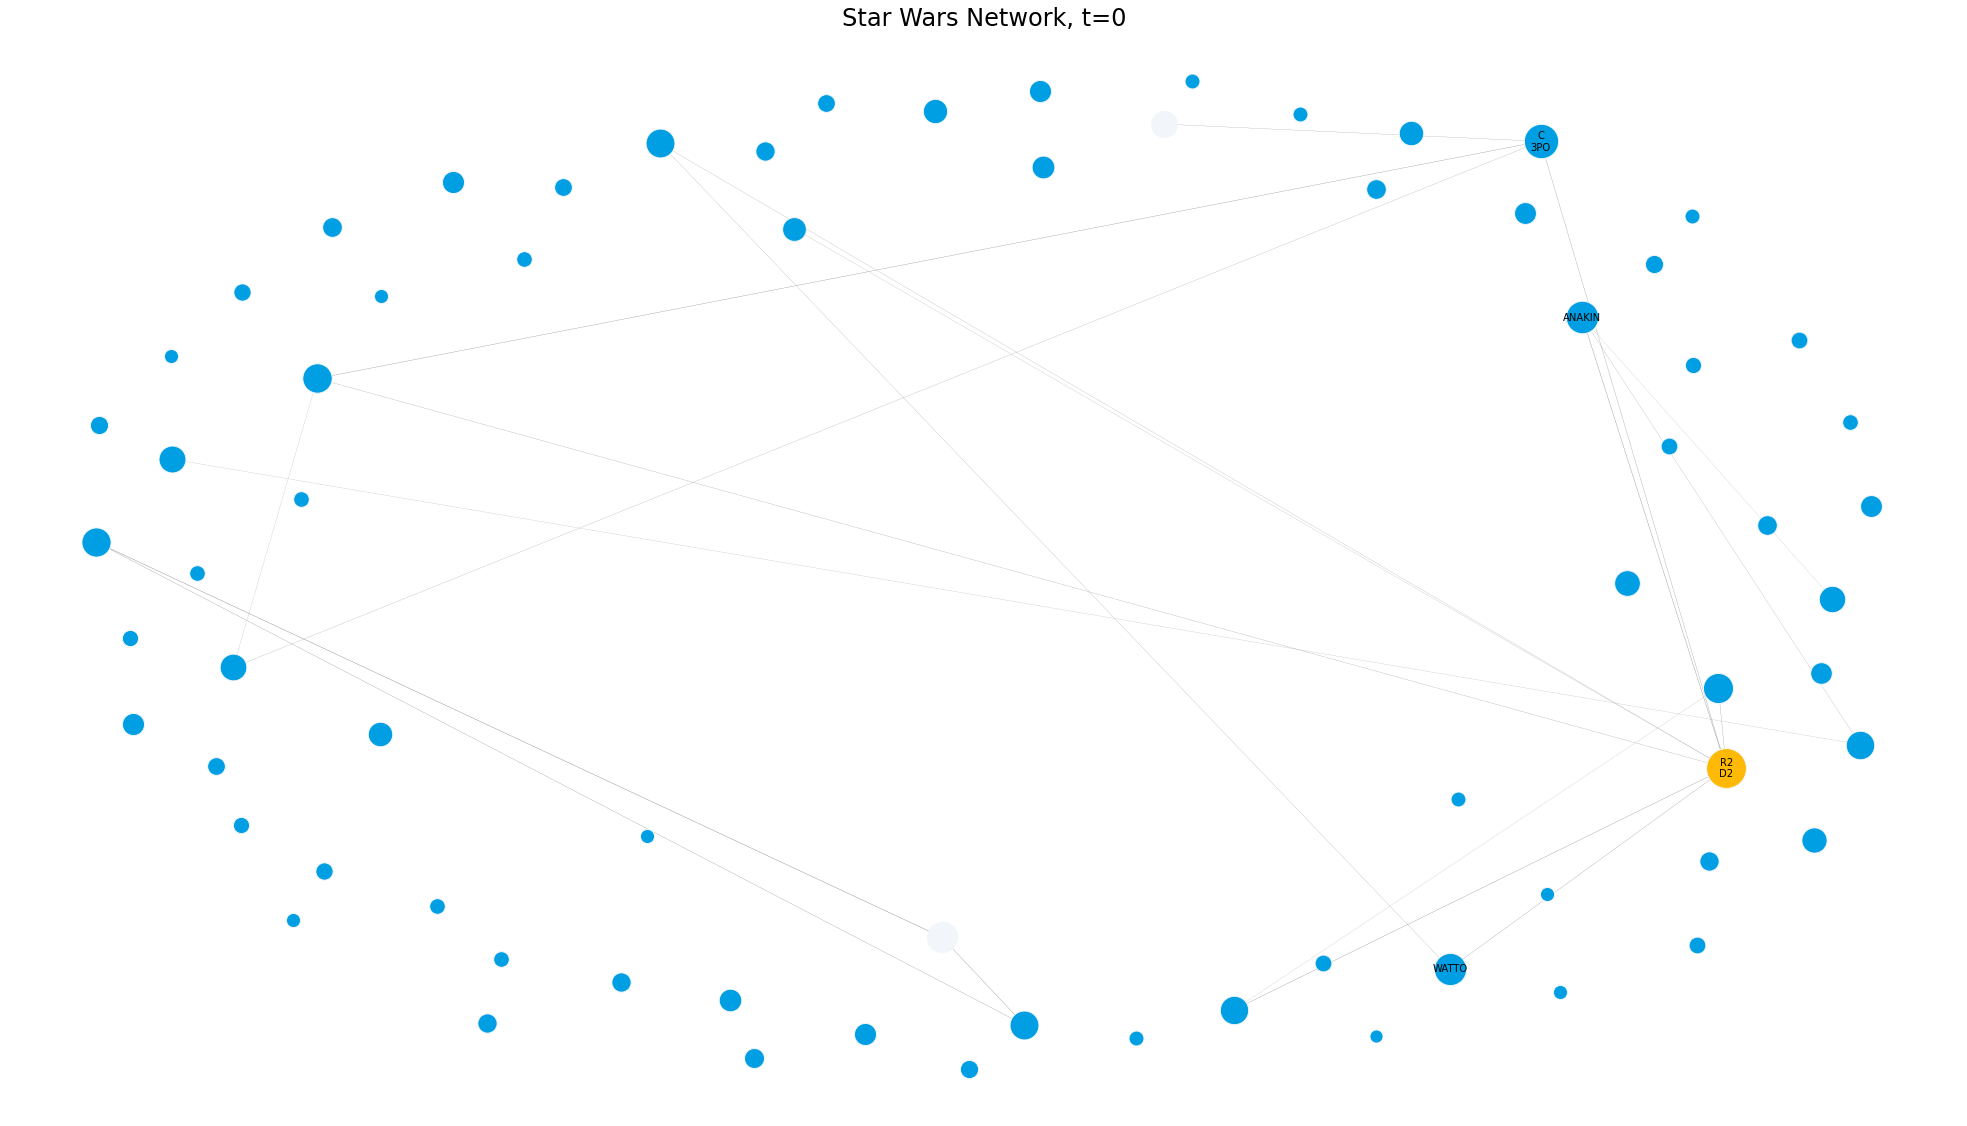

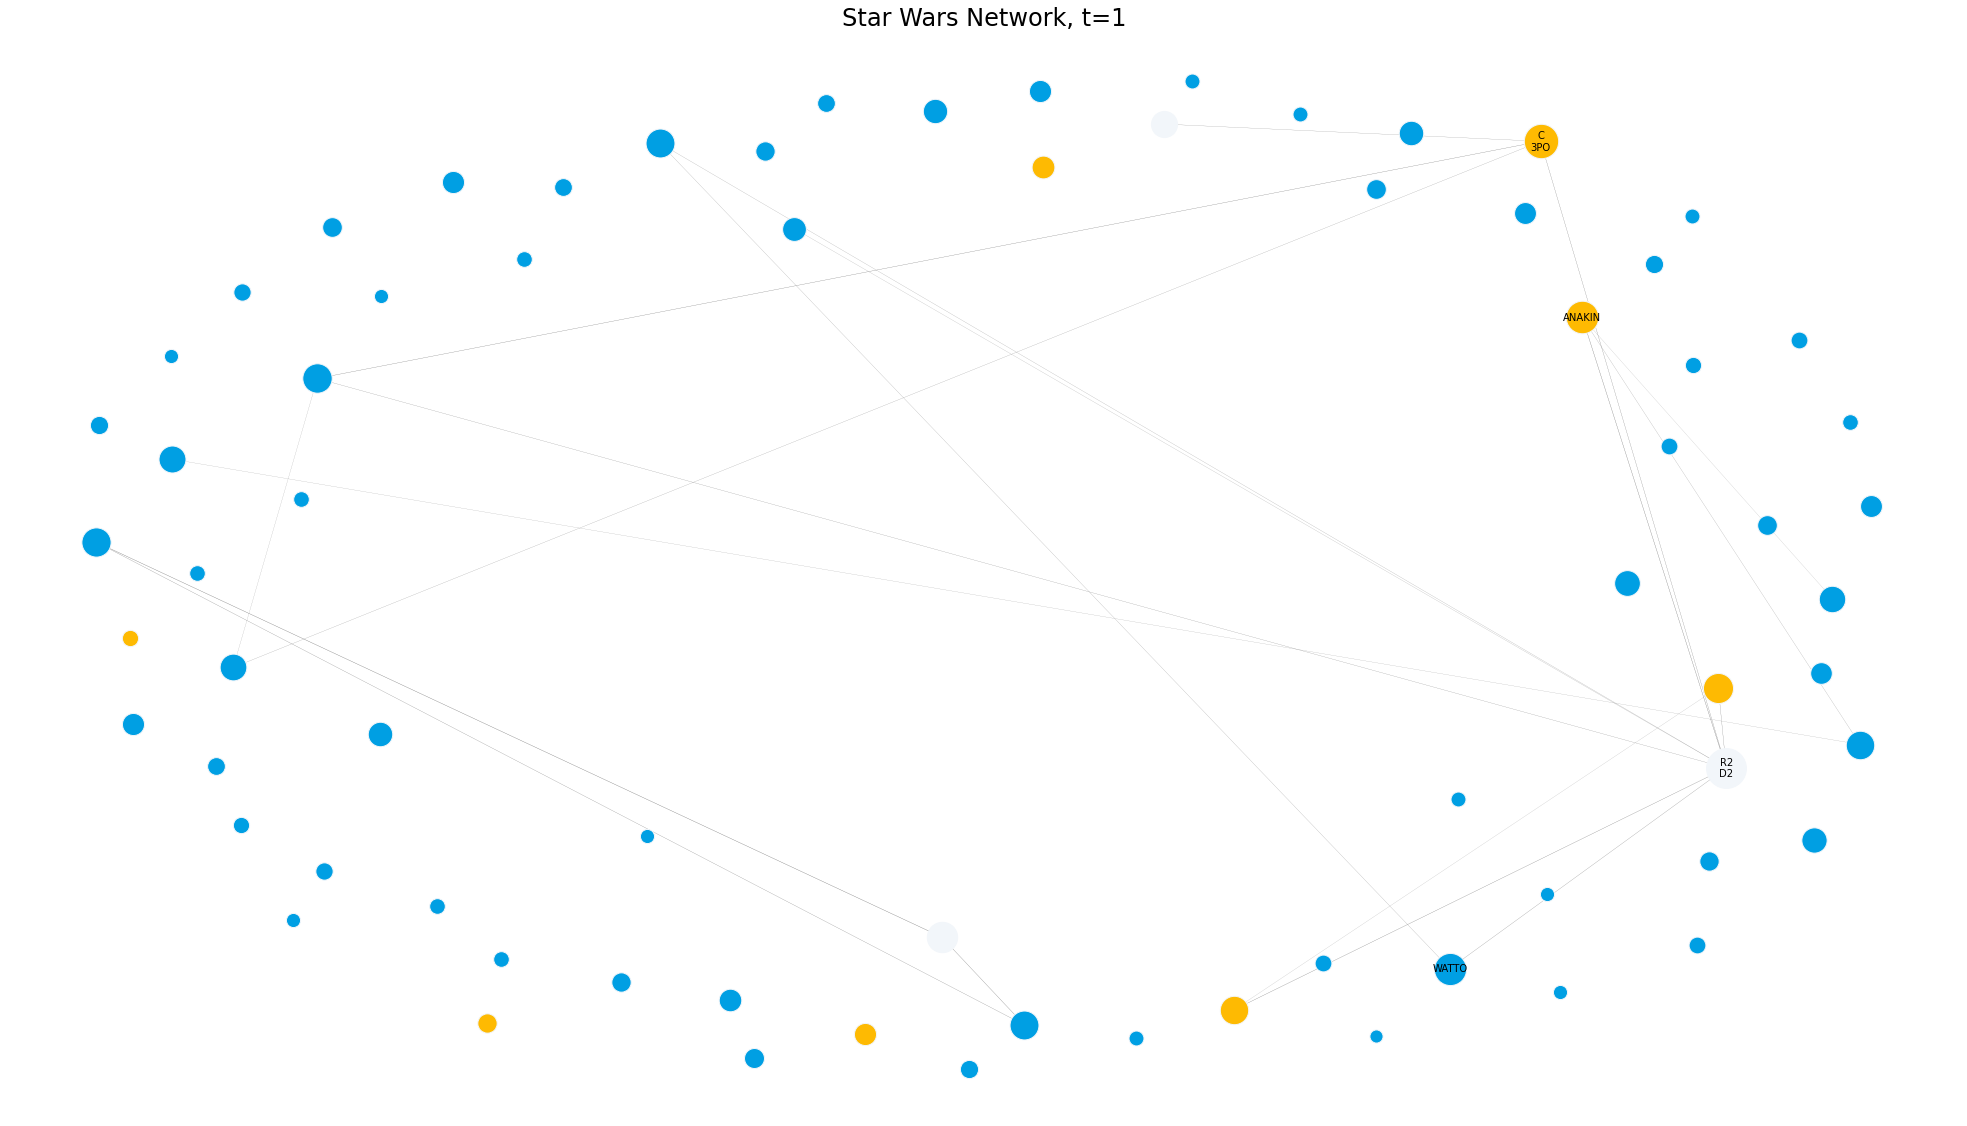

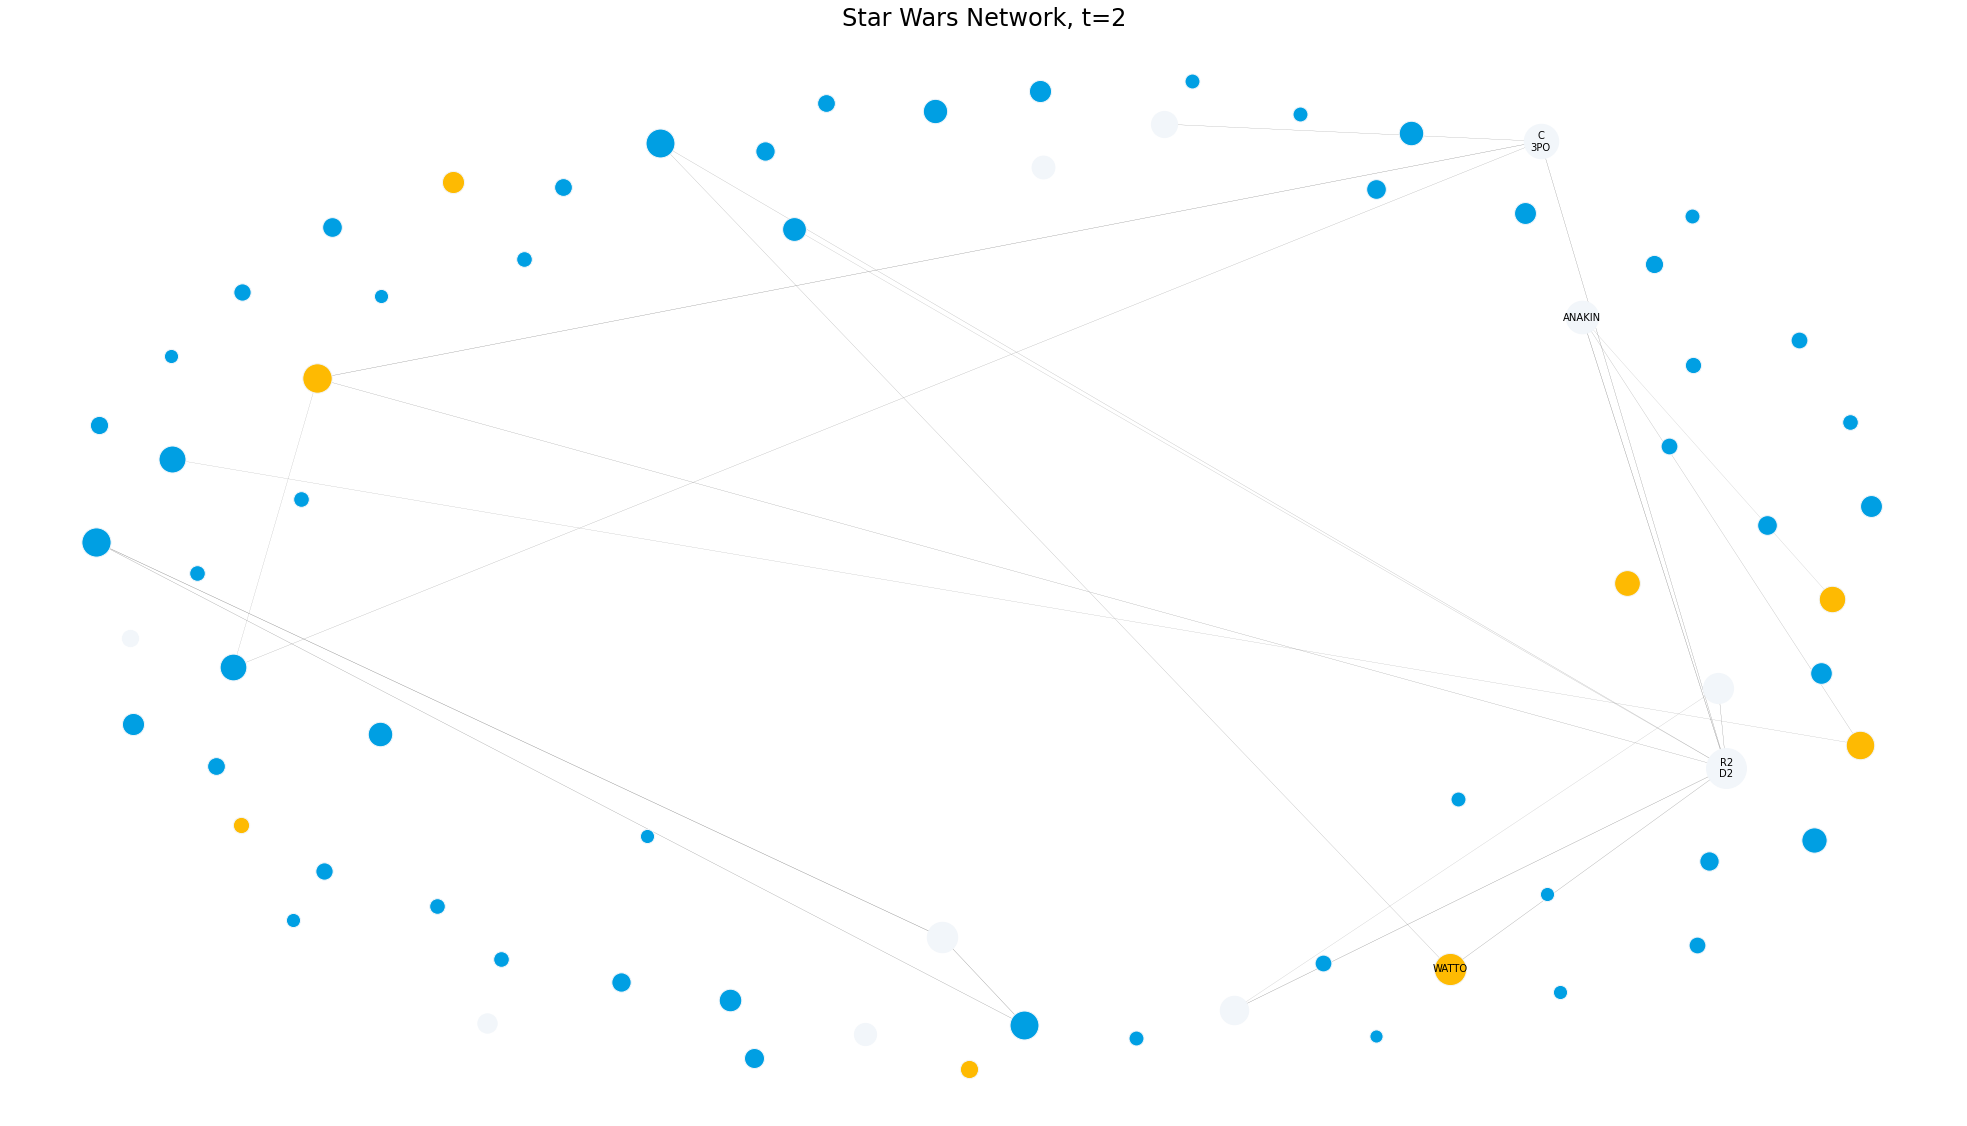

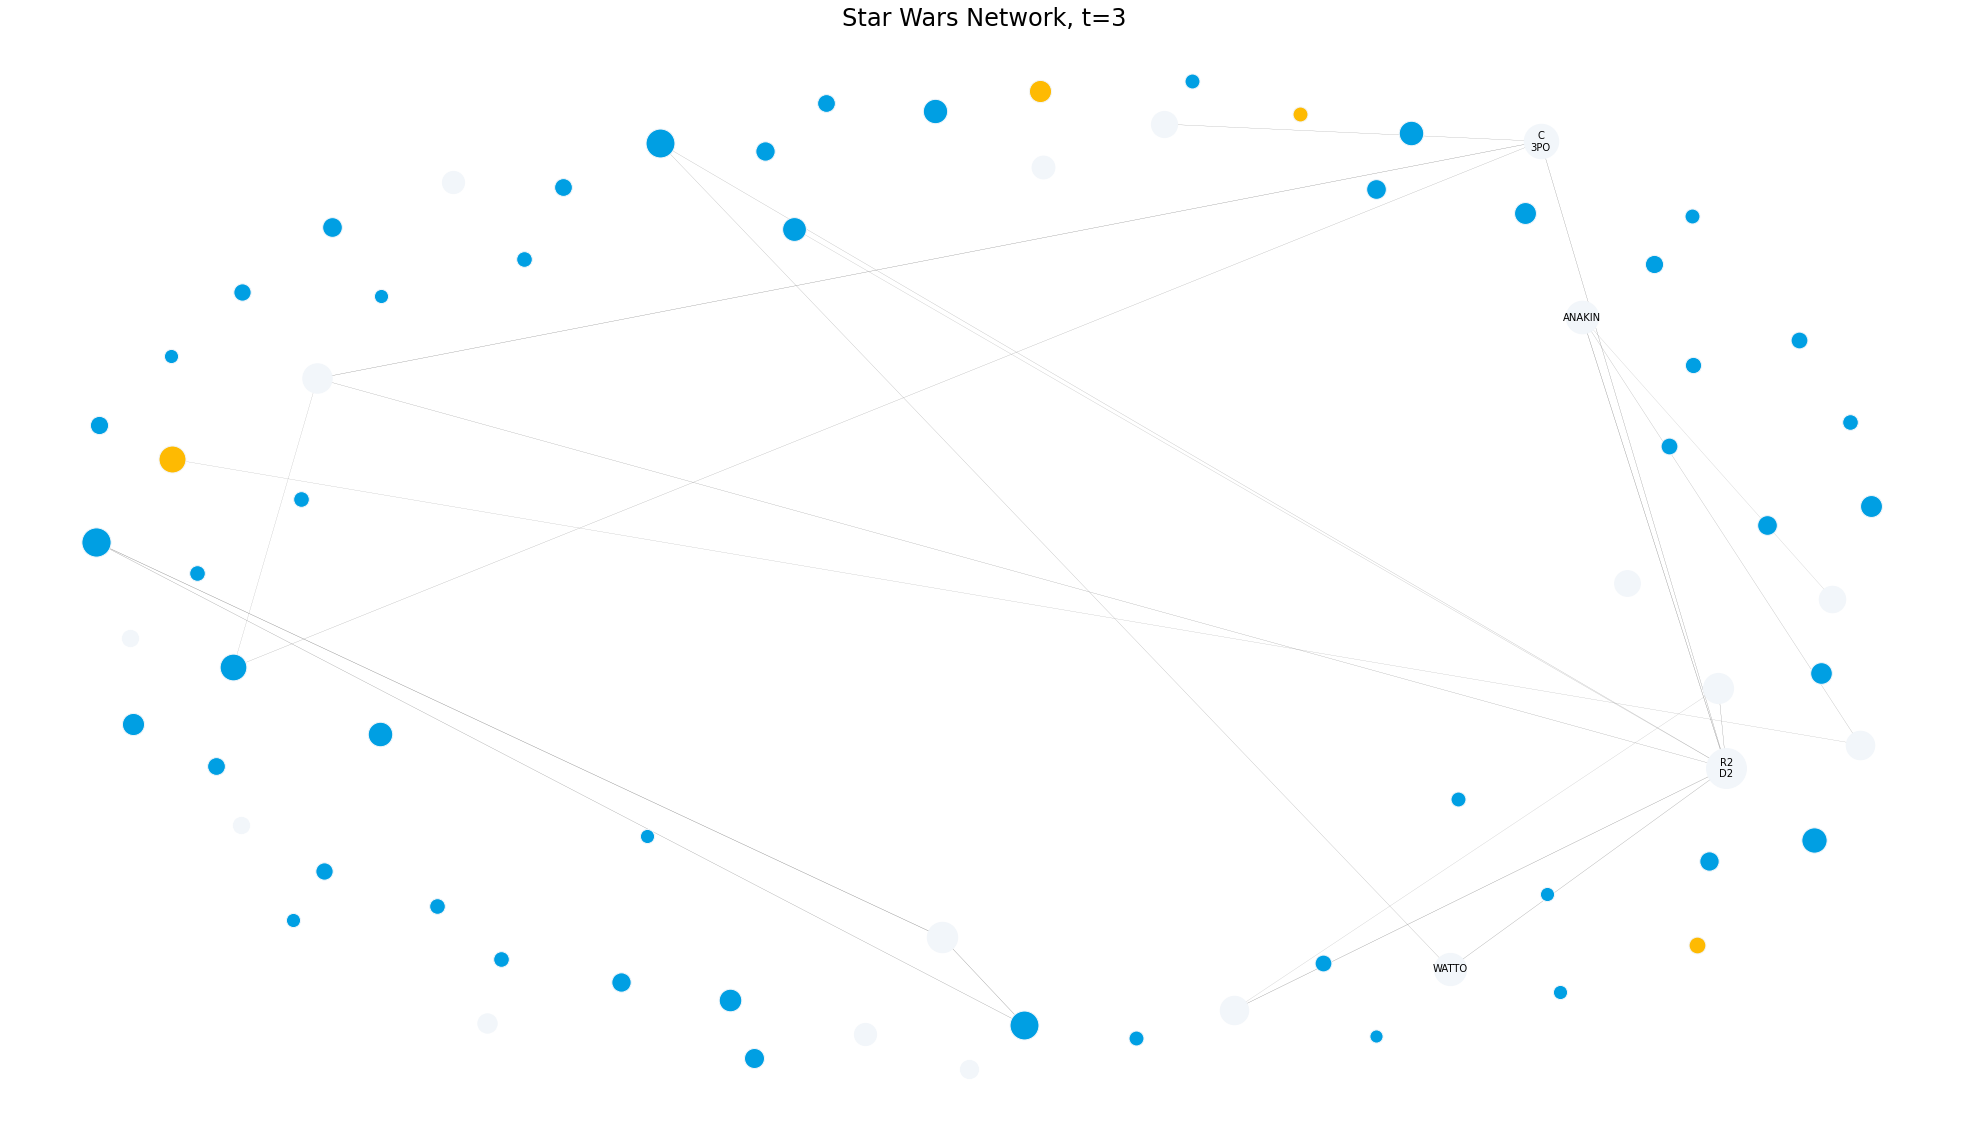

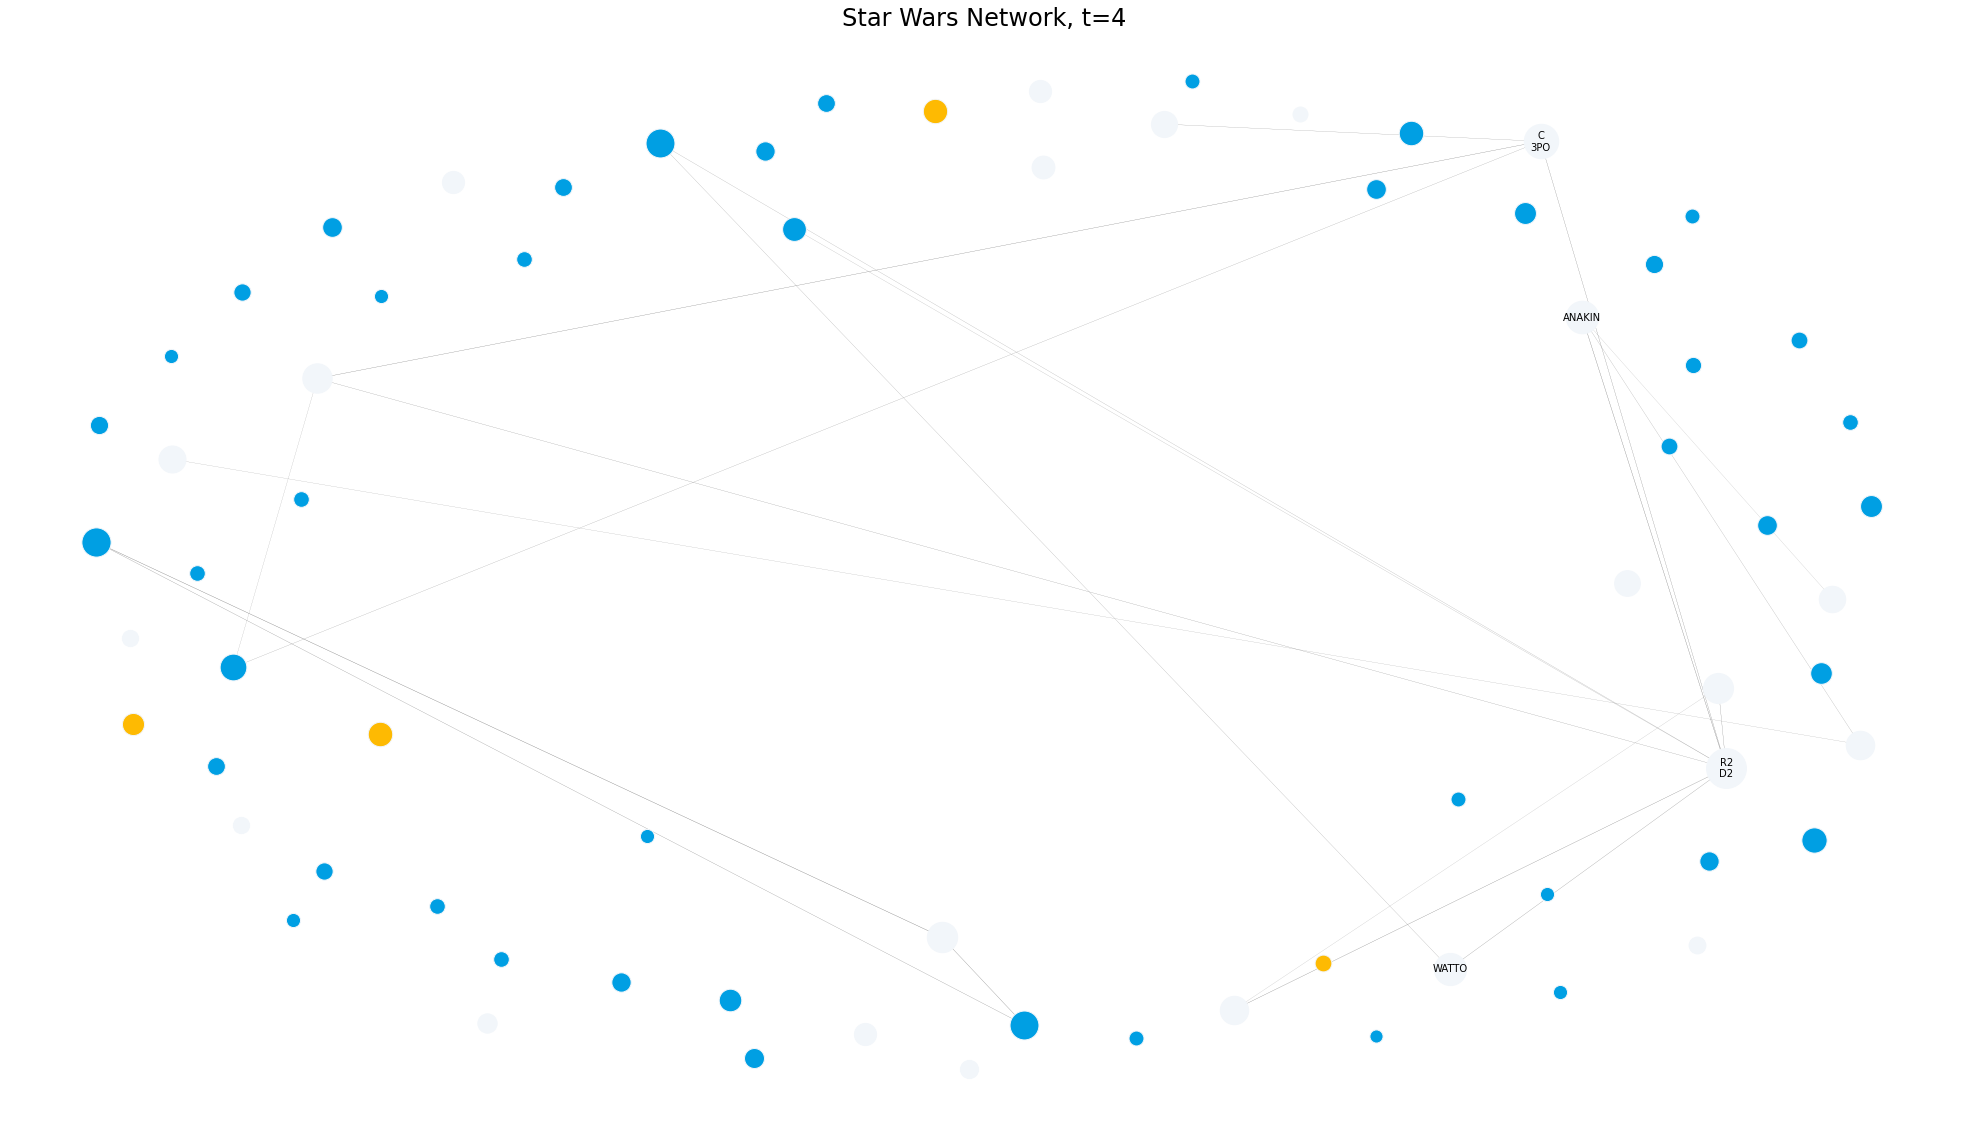

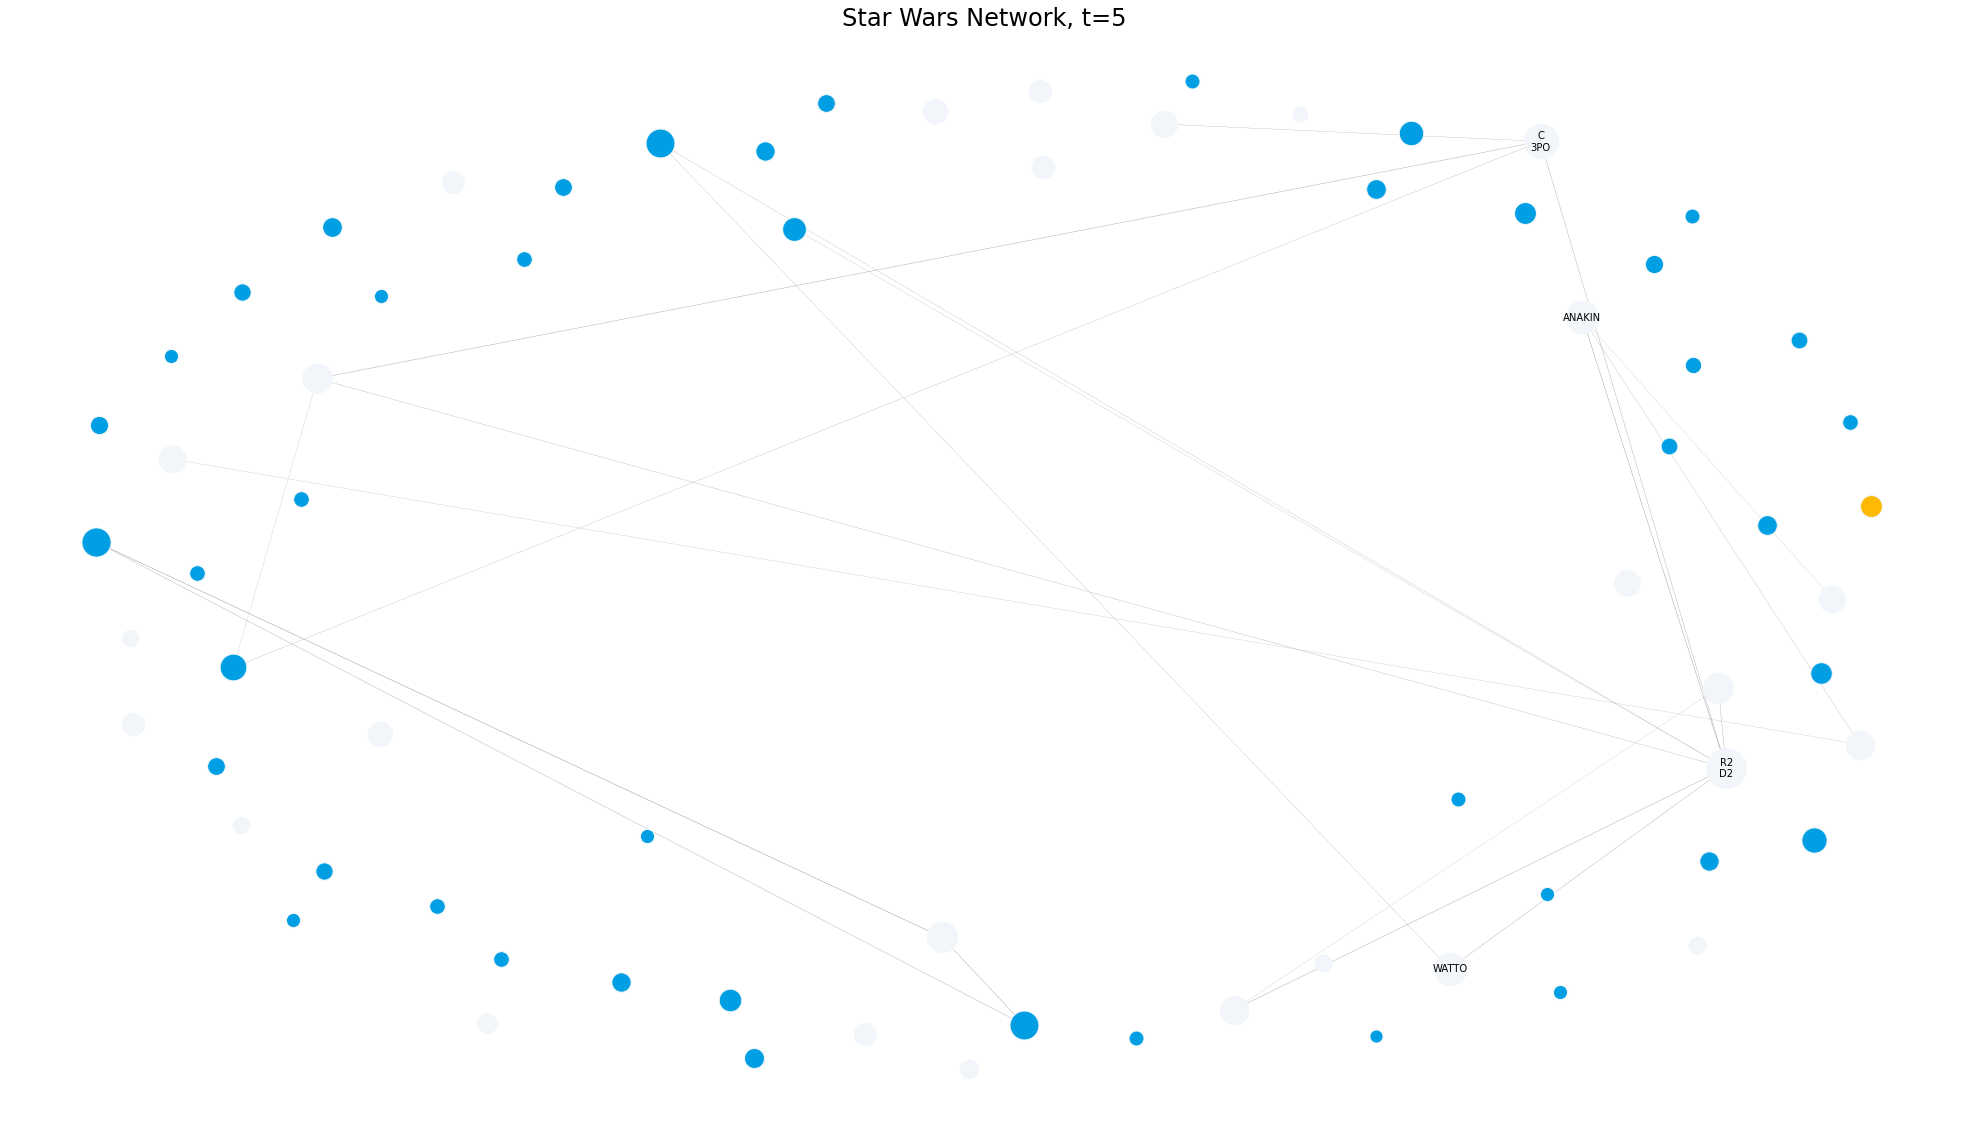

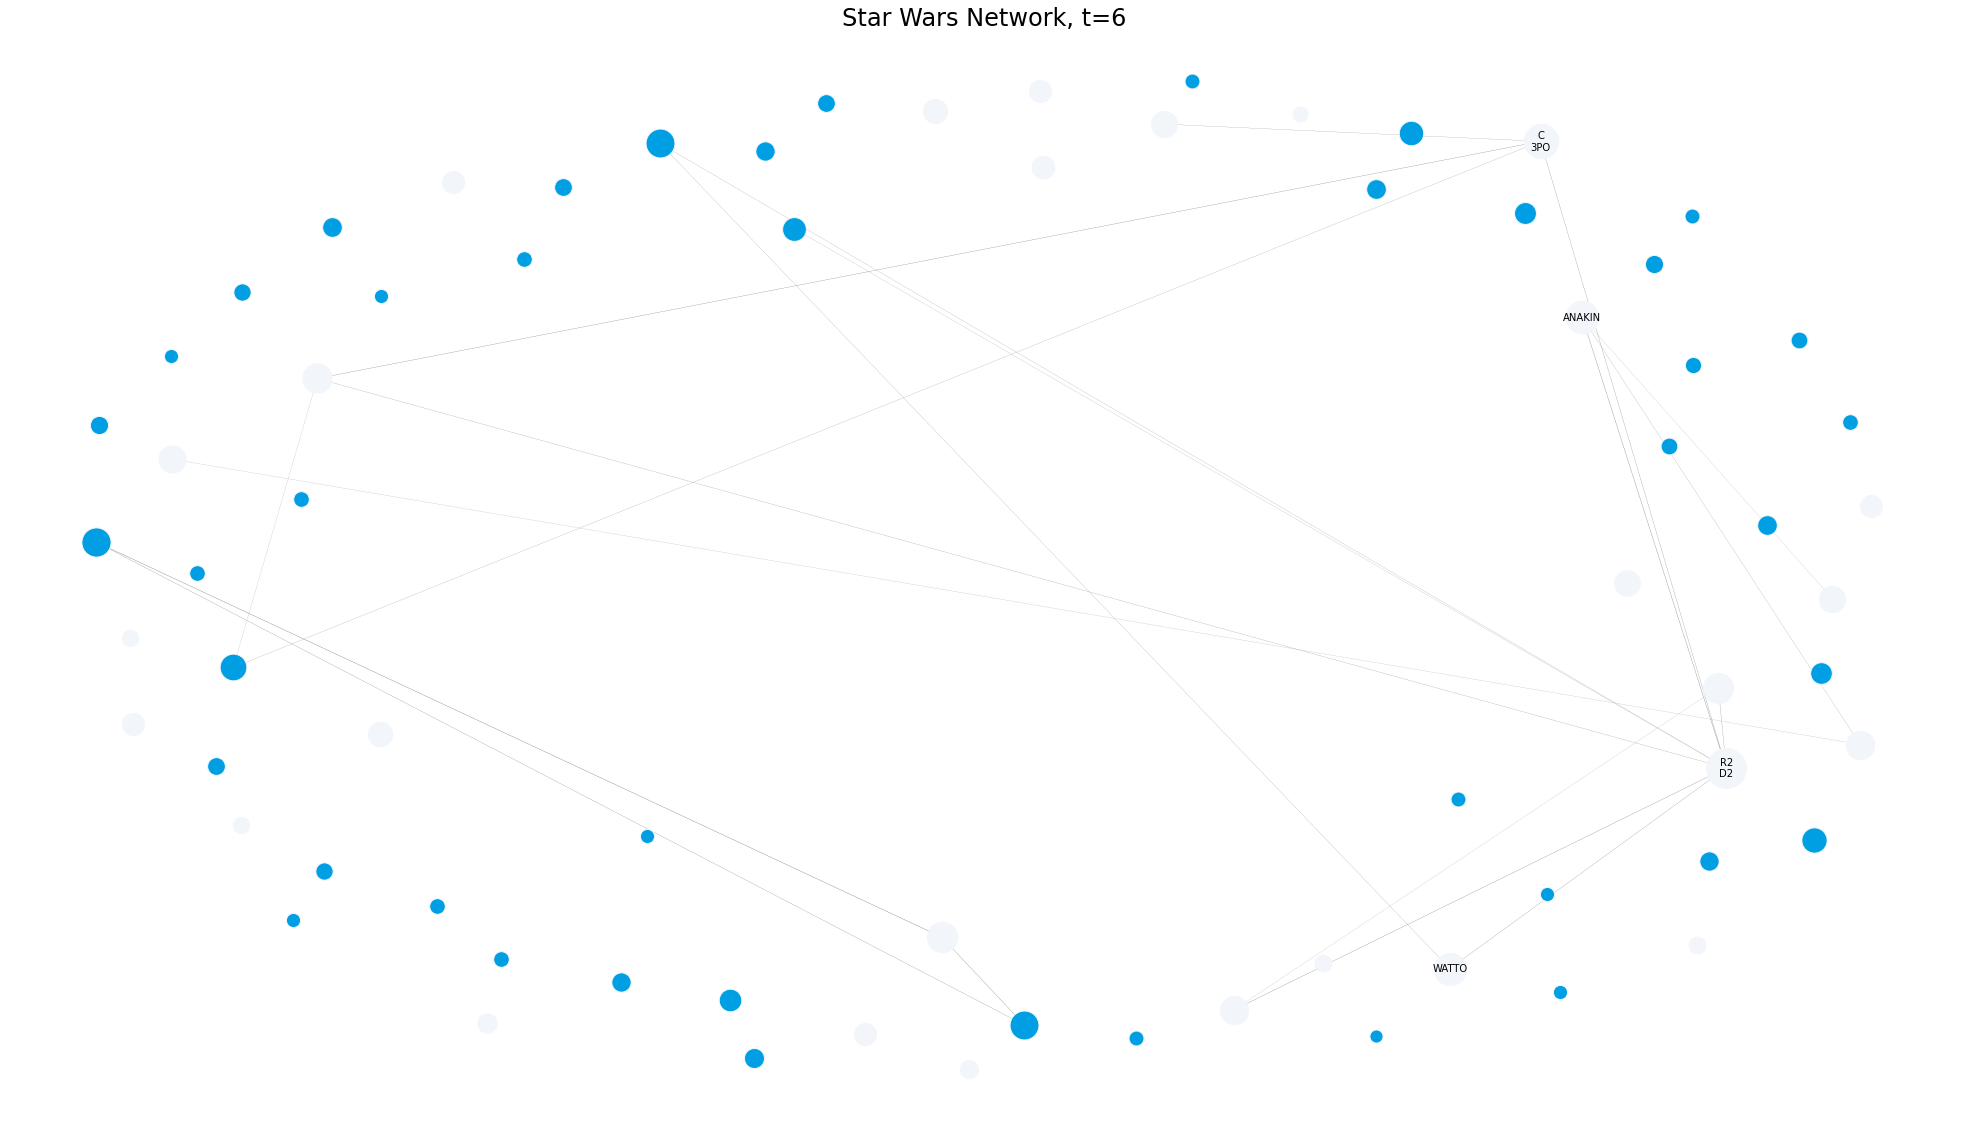

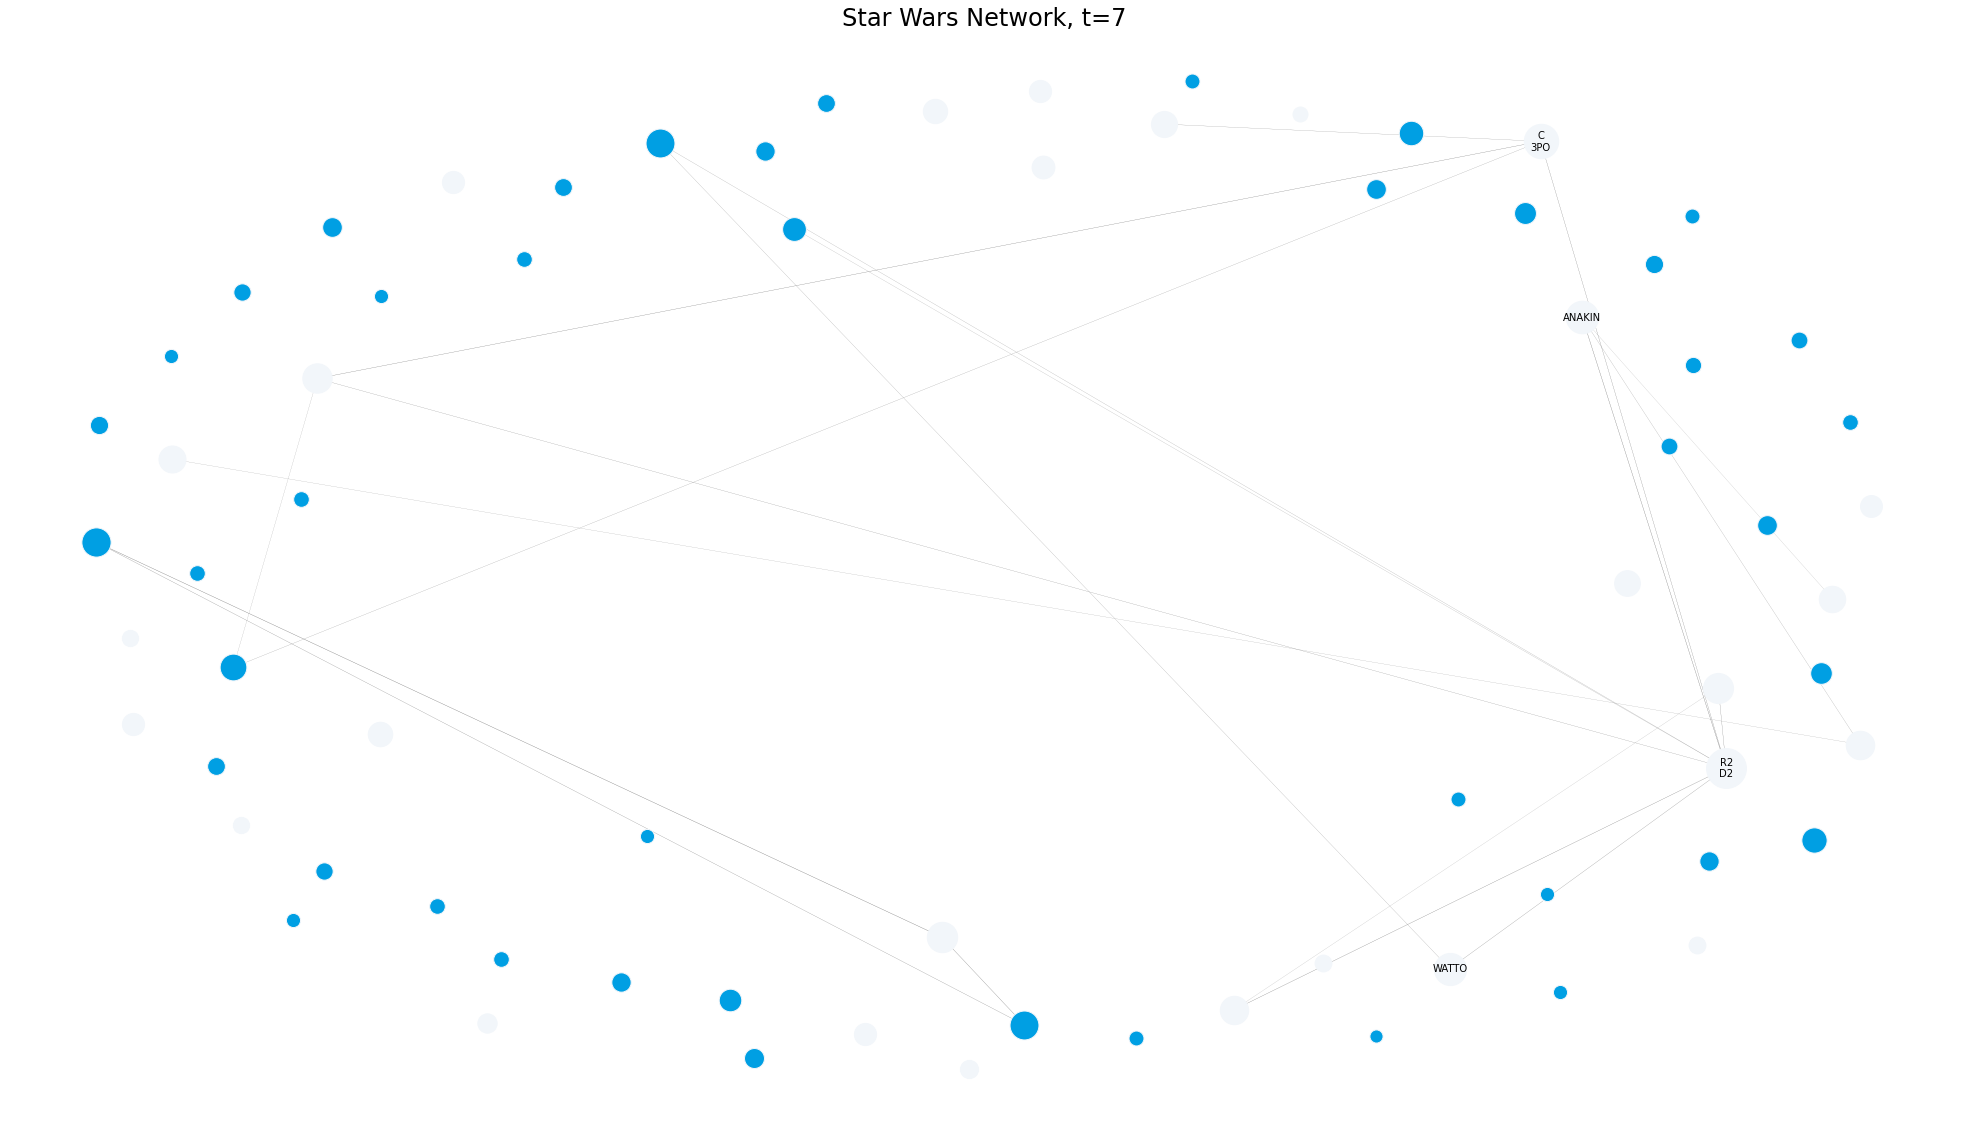

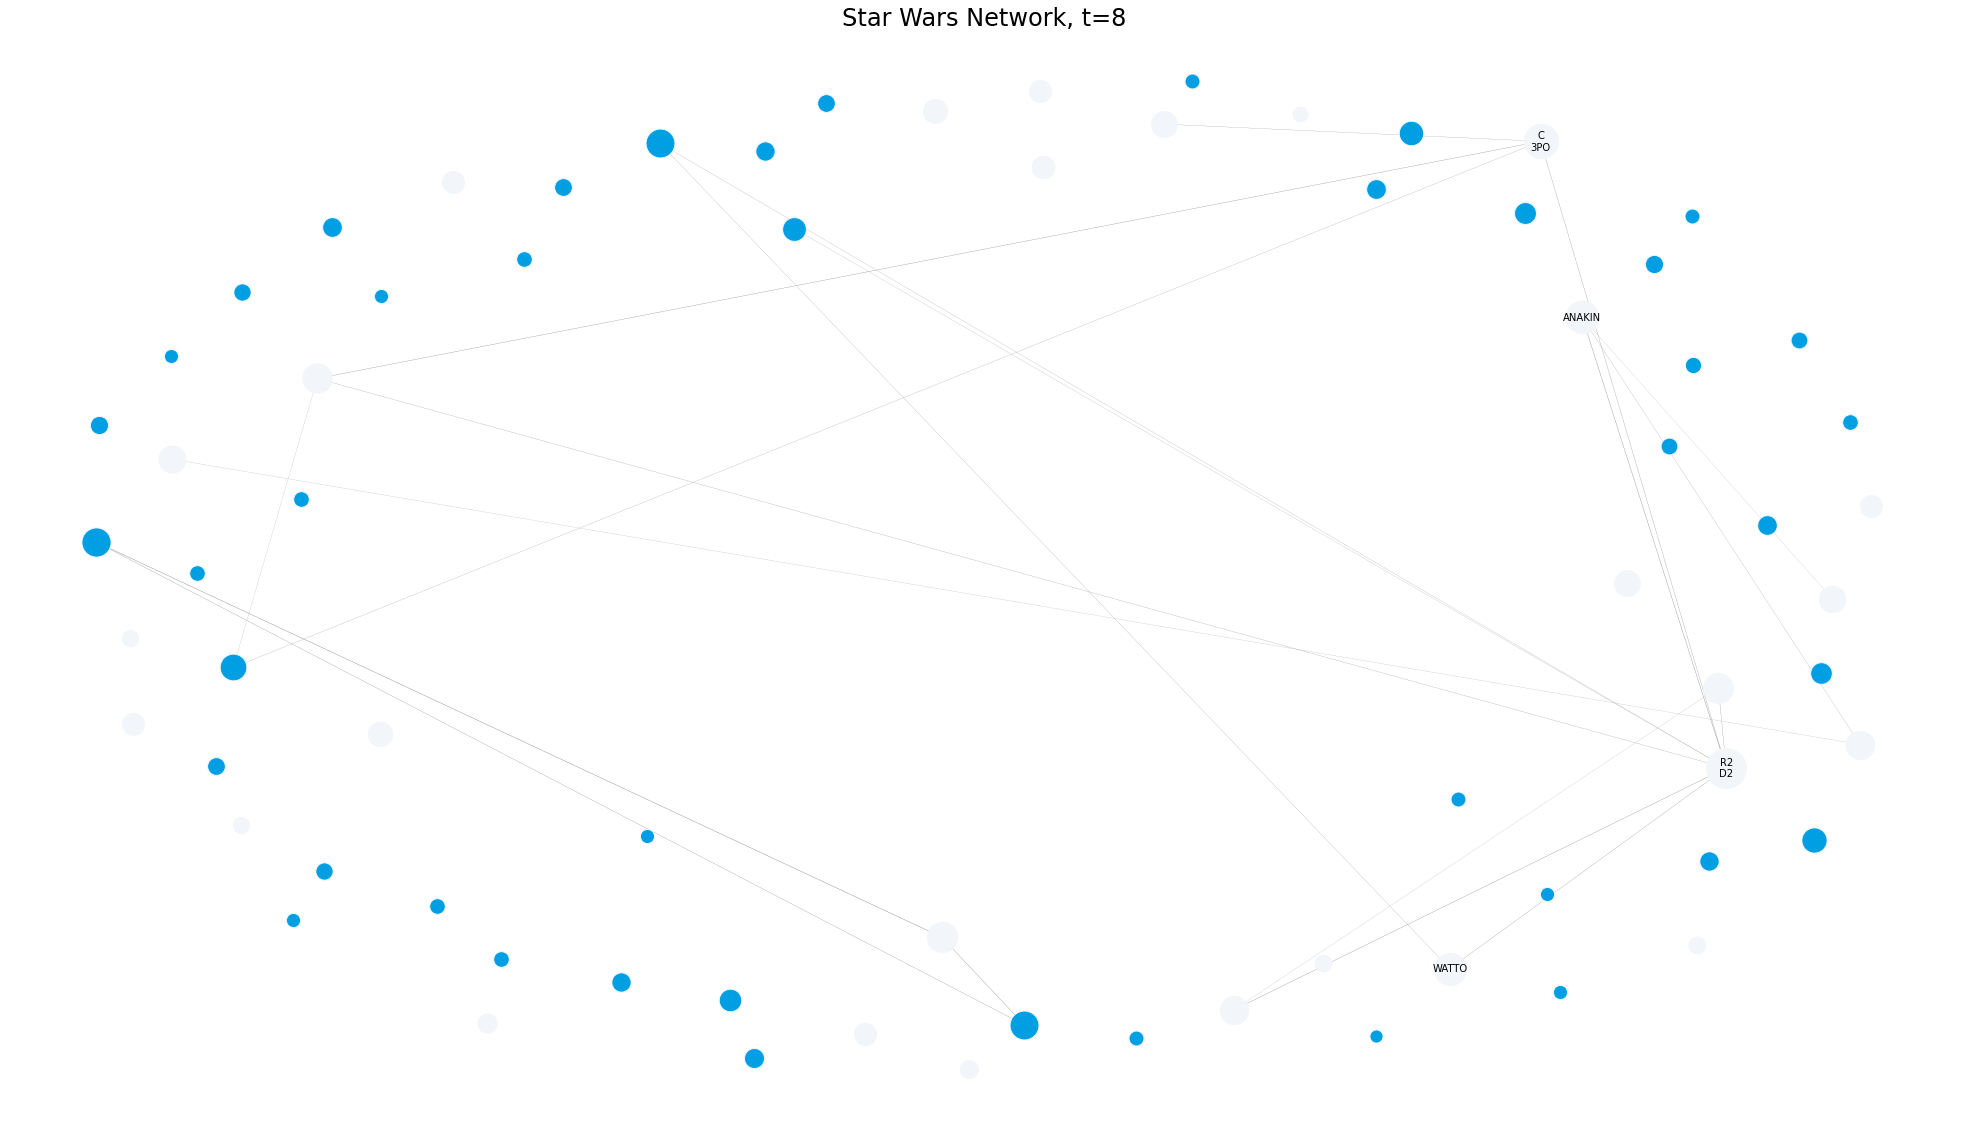

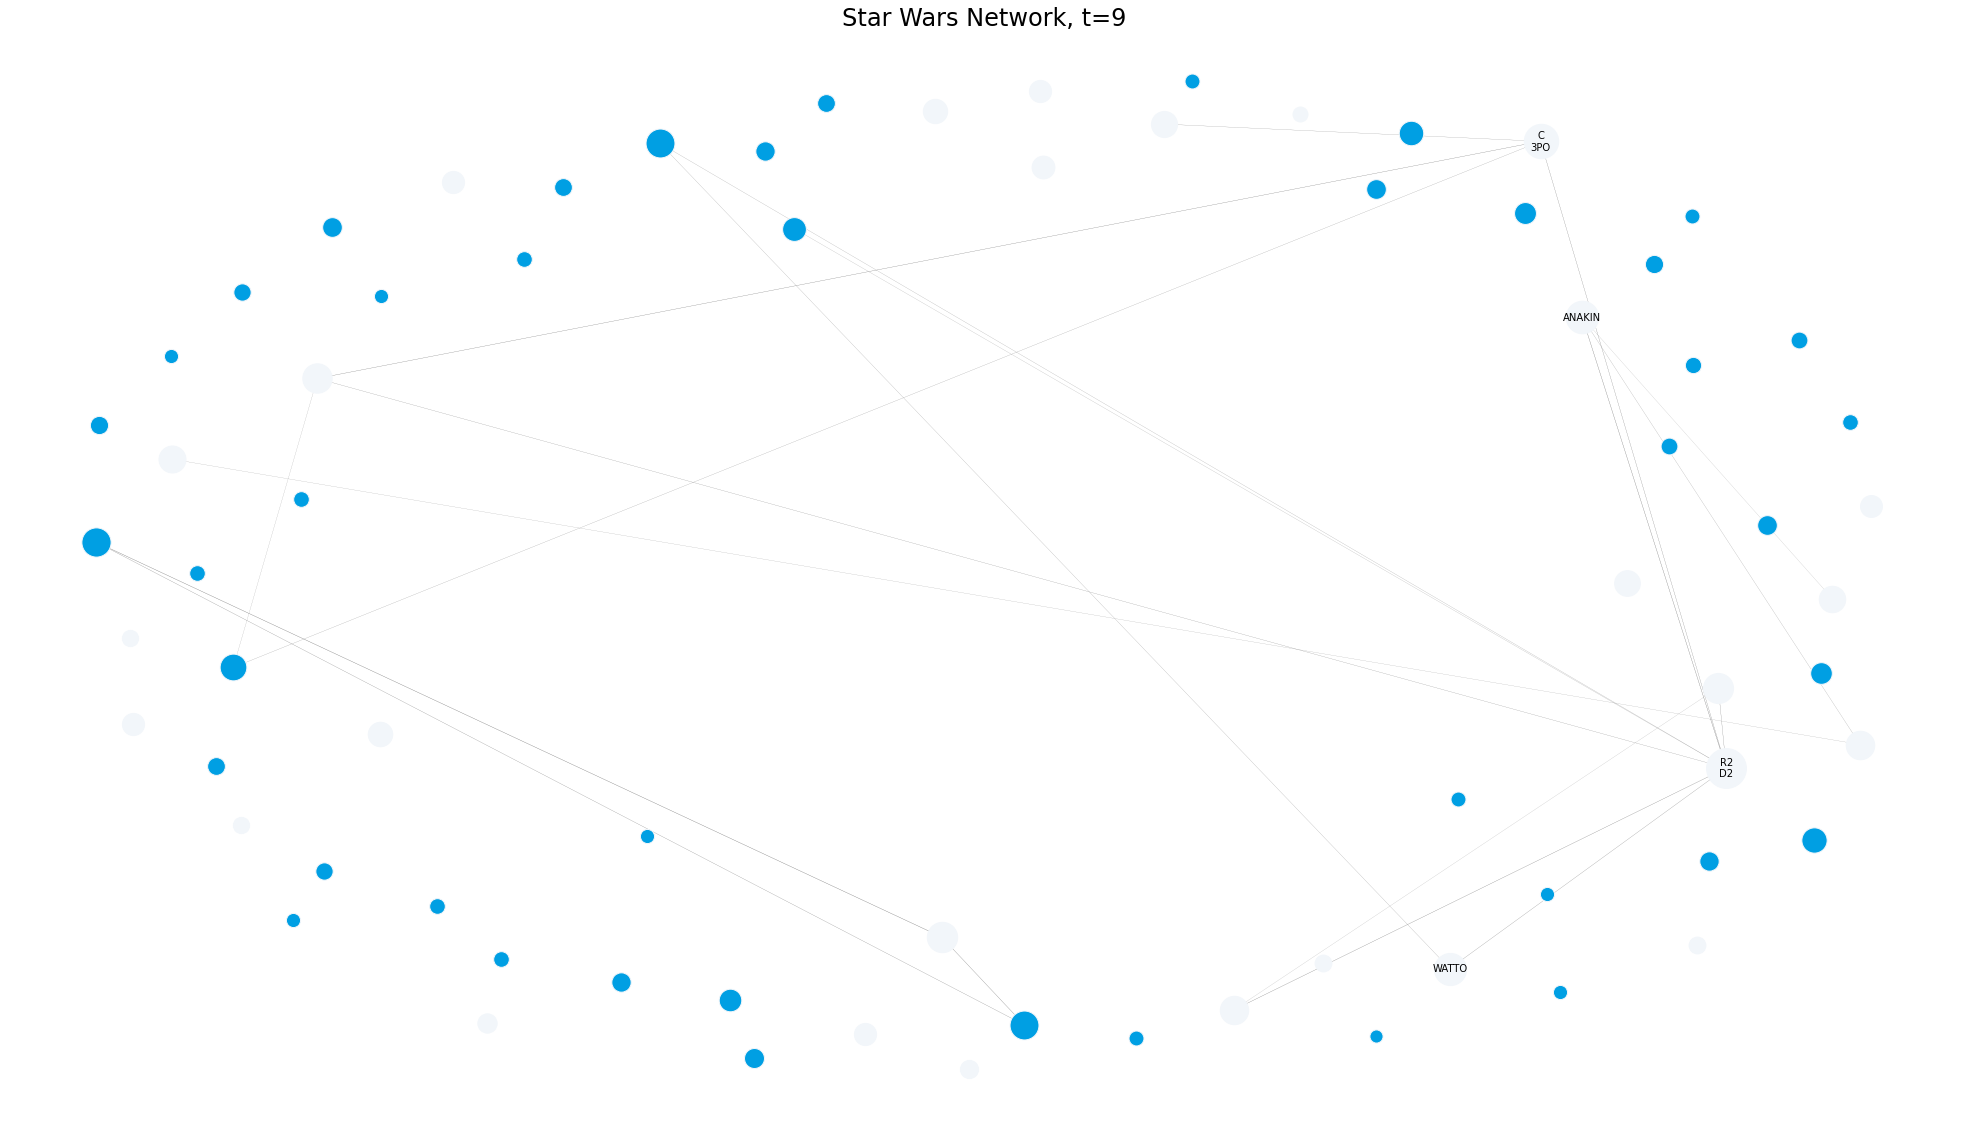

In [24]:
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade(subG,t,infection_times)

In [26]:
top = pd.DataFrame.from_dict(dict(nx.degree(subG)),orient='index').sort_values(0,ascending=False)
top.columns = ['Degree']
top['Weighted Degree'] =  pd.DataFrame.from_dict(dict(nx.degree(subG,weight='weight')),orient='index')
top['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank_numpy(subG,weight='weight')),orient='index')
top['Betweenness'] =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(subG,weight='weight')),orient='index')

In [27]:
top.head()

,Degree,Weighted Degree,PageRank,Betweenness
R2-D2,38,251,0.095454,0.186114
C-3PO,27,139,0.055358,0.076867
WATTO,26,107,0.043793,0.093224
ANAKIN,26,112,0.046605,0.056407
OBI-WAN,23,64,0.029293,0.117277


In [29]:
methods = top.columns

print(nx.info(subG))
print(nx.info(SW))

Name: 
Type: Graph
Number of nodes: 72
Number of edges: 323
Average degree:   8.9722
Name: 
Type: Graph
Number of nodes: 84
Number of edges: 342
Average degree:   8.1429


In [30]:
max_budget = len(subG.nodes())
trials = 50
all_results = []
for budget in tqdm.tqdm_notebook(range(max_budget)):
    results = {'budget':budget}
    for method in methods:
        infections = []
        for i in range(trials):
            infected = 0
            t= 0
            infection_times = {n:0 for n in top.sort_values(method,ascending=False).index[:budget]}
            while len(infection_times)>infected:
                #t+=1
                infected = len(infection_times)
                infection_times = independent_cascade(subG,t,infection_times)
                t+=1
            infections.append(infected)
        results[method] = np.round(np.mean(infections)/len(subG.nodes()),2)

    all_results.append(results)
              

  0%|          | 0/72 [00:00<?, ?it/s]

In [31]:
res_df = pd.concat([pd.DataFrame.from_dict(r,orient='index').T 
                        for r in all_results]).set_index('budget')

In [32]:
res_df.index = res_df.index/len(subG.nodes())

In [33]:
res_df.head()

,Degree,Weighted Degree,PageRank,Betweenness
budget,,,,
0.000000,0.00,0.00,0.00,0.00
0.013889,0.32,0.30,0.31,0.05
0.027778,0.32,0.31,0.30,0.32
0.041667,0.33,0.32,0.32,0.32
0.055556,0.31,0.32,0.31,0.35


Text(0.5, 0, 'Seeding Budget (out of graph size)')

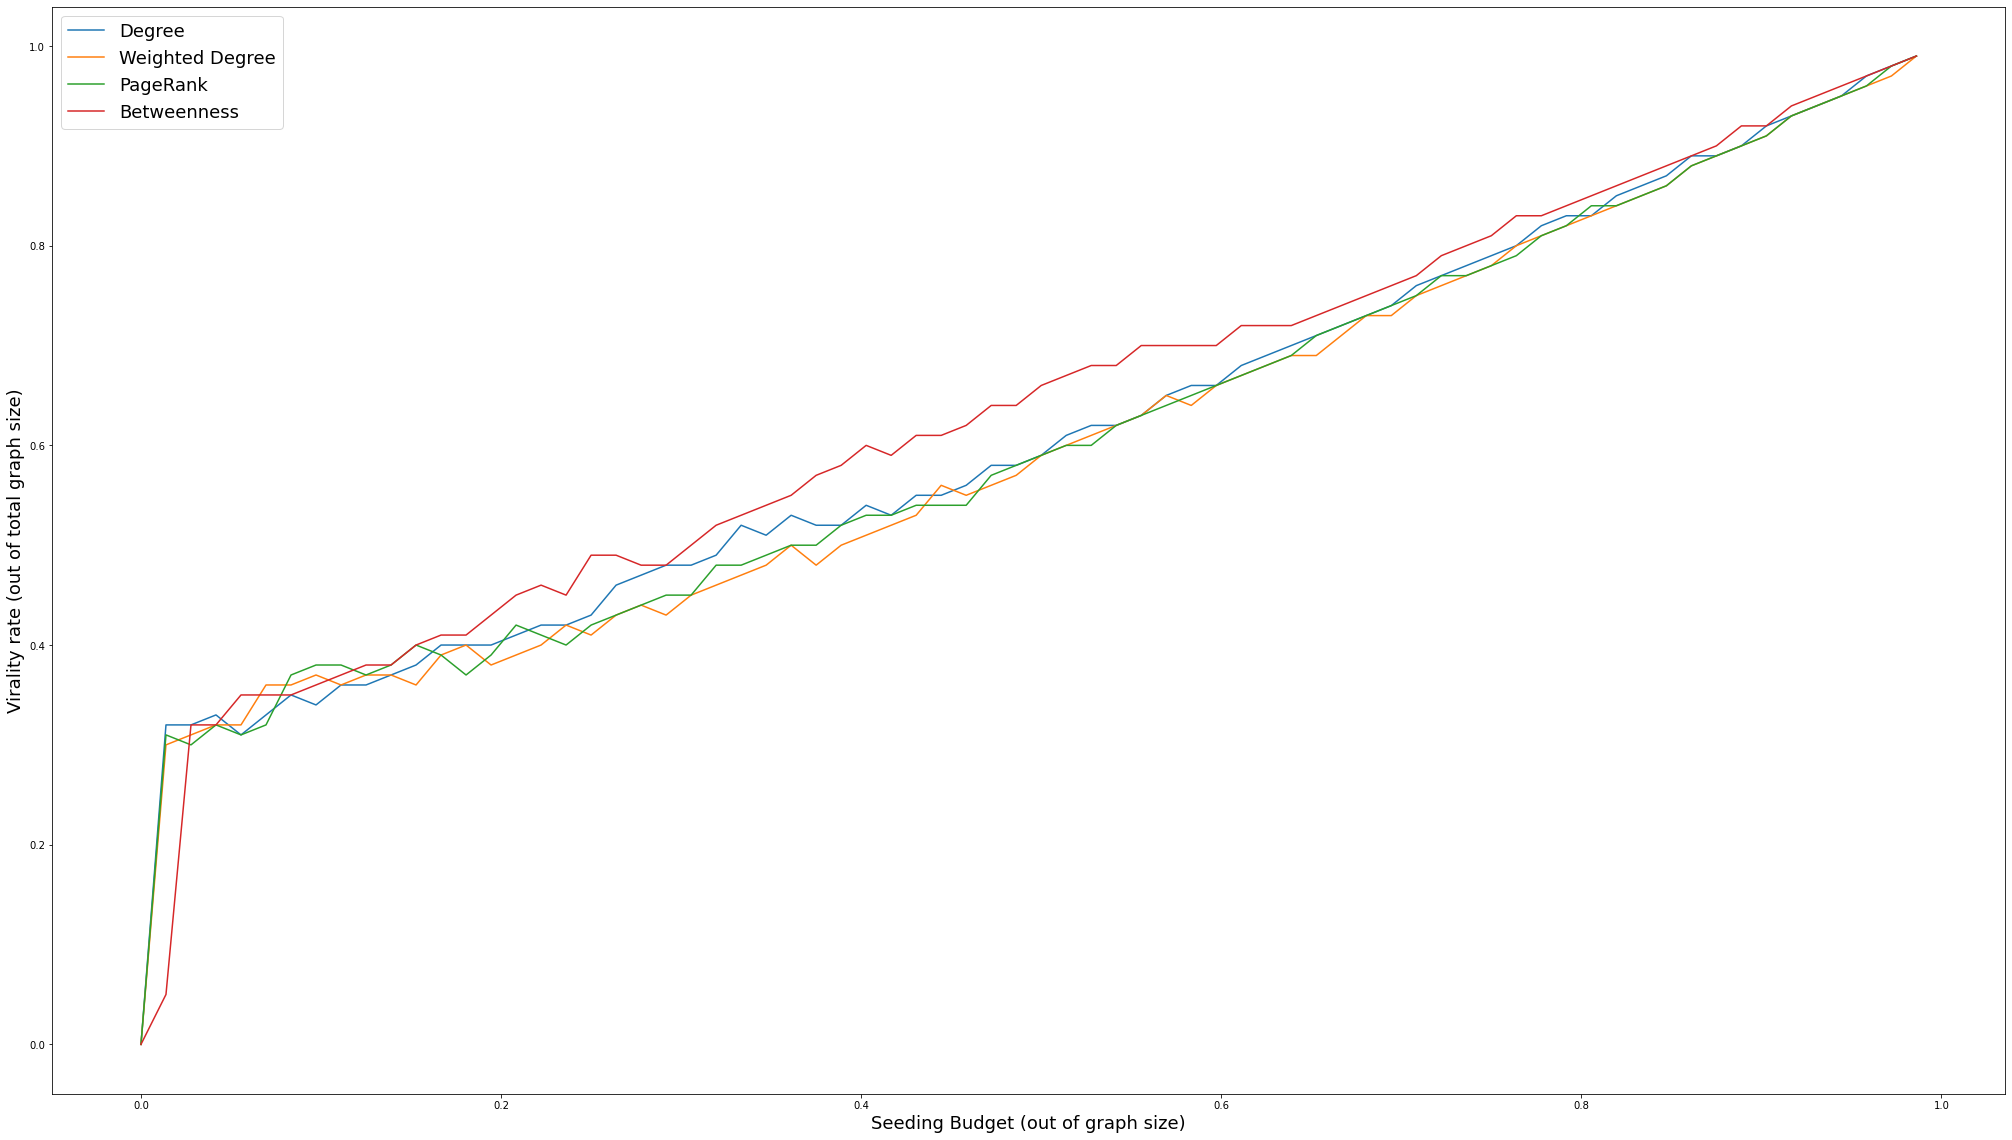

In [34]:
res_df.plot()
plt.legend(fontsize = 18)
plt.ylabel('Virality rate (out of total graph size)',fontsize = 18)
plt.xlabel('Seeding Budget (out of graph size)', fontsize = 18)

In [35]:
from itertools import product

budget=2

seed_sets = list(product(*[subG.nodes()]*budget))

print(len(seed_sets),'Seeding options')

5184 Seeding options


In [ ]:
budget = 2
trials = 20
all_results = []
results = {'budget':budget}
for seed in tqdm.tqdm_notebook(seed_sets[:]):
    infections = []
    for i in range(trials):
        infected = 0
        t= 0
        infection_times = {n:0 for n in seed}
        while len(infection_times)>infected:
            #t+=1
            infected = len(infection_times)
            infection_times = independent_cascade(subG,t,infection_times)
            t+=1
        infections.append(infected)
    results[seed] = np.round(np.mean(infections)/len(subG.nodes()),2)

all_results.append(results)

  0%|          | 0/5184 [00:00<?, ?it/s]

In [ ]:
sorted(results.items(), key = lambda x: x[1], reverse=True)[:10]